In [1]:
#Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMG_SIZE = 256
BATCH_SIZE=32
CHANNELS = 3
EPOCHS = 10

In [3]:
#Import data set as batch wise due to size of data set. This technique is used to reduce the load on RAM when data loading when training the model.
#tf.data.dataset technique is using when handling the large data set such as 1 million images. 
#This technique load to RAM batch as we defined the in the batch size

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", shuffle = True, image_size=(IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE  
)

Found 2152 files belonging to 3 classes.


In [4]:
#The data loading technique is defined the class names as per the folders created inside the data directory
#Therefore, in this technique we have to initially sort the images for relevant folders named.
#The folder names are getting as the class_names

class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

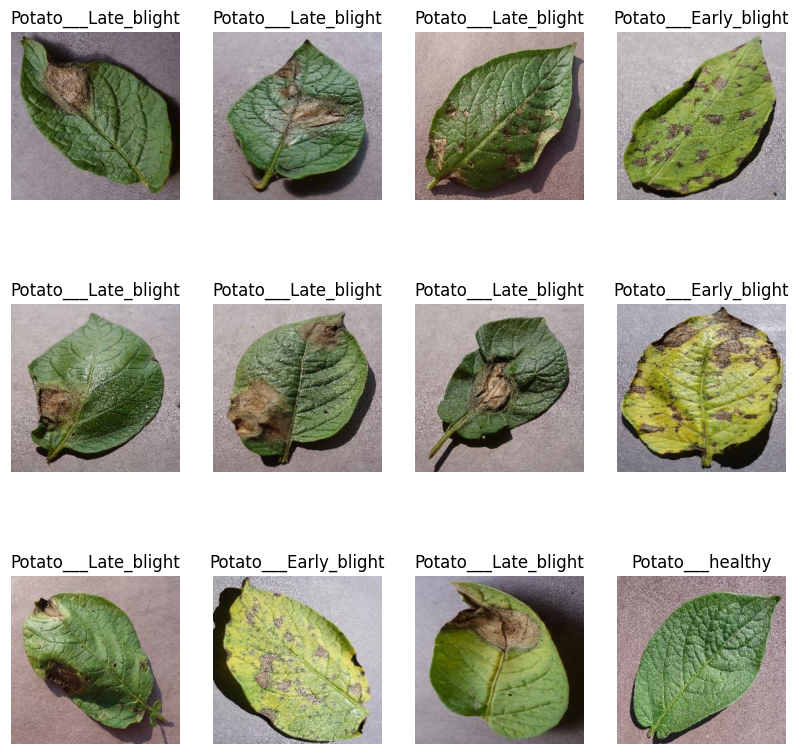

In [7]:
#Plot sample images from the data set

plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')    
    
    

In [8]:
#Define a function to split the data set

def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000): 
    ds_size = len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=123)
    
    train_size = int(train_split*ds_size) 
    val_size = int(val_split*ds_size) 
     
    train_ds=ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)    #when using the take function, selects number of images as given in the value
    test_ds = ds.skip(train_size).skip(val_size)
        
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)   #Use defined function to split the data set

In [10]:
len(train_ds)

54

In [11]:
#After the first epoch the dataset run again. Therefore, the filters and map functions need to run gagai. To avoid this, cache is using.
#Prefetch is used parallel computing option of CPU and GPU. Therefore, the CPU can ready for the next batch when the GPU is working on the training.

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
#Resize and scaling
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255)
])

In [13]:
#Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2)])

In [18]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes = 3
#Define the convolutional model
model = models.Sequential([
    resize_and_rescale,                         #first two layes for scaling and augmentations
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),      #Used siz convolutional layers and pooling layers
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),                                         #Fully connected layer as flatten layer
    layers.Dense(n_classes,activation='softmax'),                               #Softmax activation used due to multiclass classification problem
                          
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#Compiling model with adam optimizer and loss function.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
#Training the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    )

Epoch 1/10


54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 840ms/step - accuracy: 0.4647 - loss: 0.9437 - val_accuracy: 0.4219 - val_loss: 0.9052
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 851ms/step - accuracy: 0.6062 - loss: 0.7941 - val_accuracy: 0.7500 - val_loss: 0.6632
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 847ms/step - accuracy: 0.7108 - loss: 0.6336 - val_accuracy: 0.8021 - val_loss: 0.5510
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 866ms/step - accuracy: 0.8217 - loss: 0.4714 - val_accuracy: 0.7865 - val_loss: 0.5549
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 883ms/step - accuracy: 0.8619 - loss: 0.3380 - val_accuracy: 0.8750 - val_loss: 0.4081
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 928ms/step - accuracy: 0.8862 - loss: 0.2669 - val_accuracy: 0.8802 - val_loss: 0.2863
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9071 - loss: 0.2525 - val_accuracy: 0.9271 - val_loss: 0.1867
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9406 - loss: 0.1476 - val_accuracy: 0.9167 - va

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [23]:
#List each key in the history dictionary for visualization the training progress
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

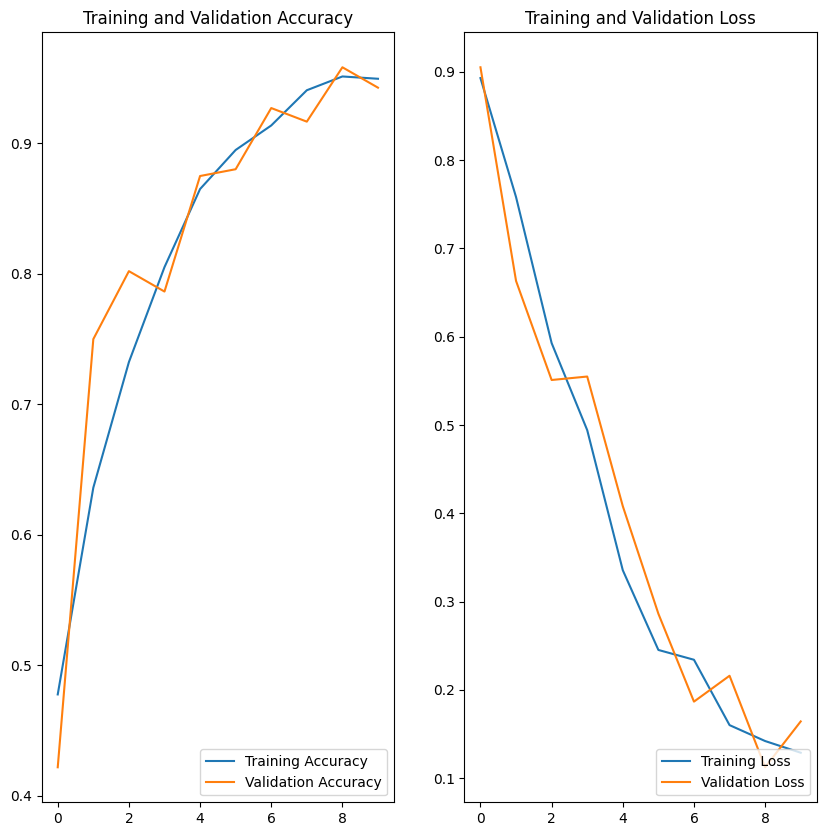

In [24]:
#Visualize the training and validation accuracies and losses 
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Predicted label: 1


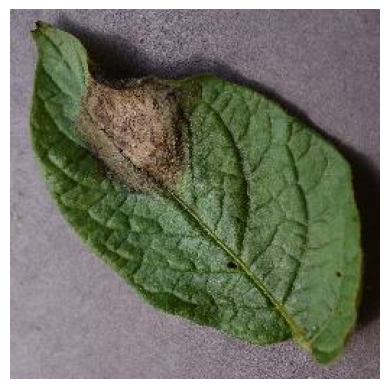

In [25]:
#Get prediction from the trained model
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('Predicted label:', np.argmax(batch_prediction[0]))

In [26]:
#Ddefine a function for predict the class of image and confidence 
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


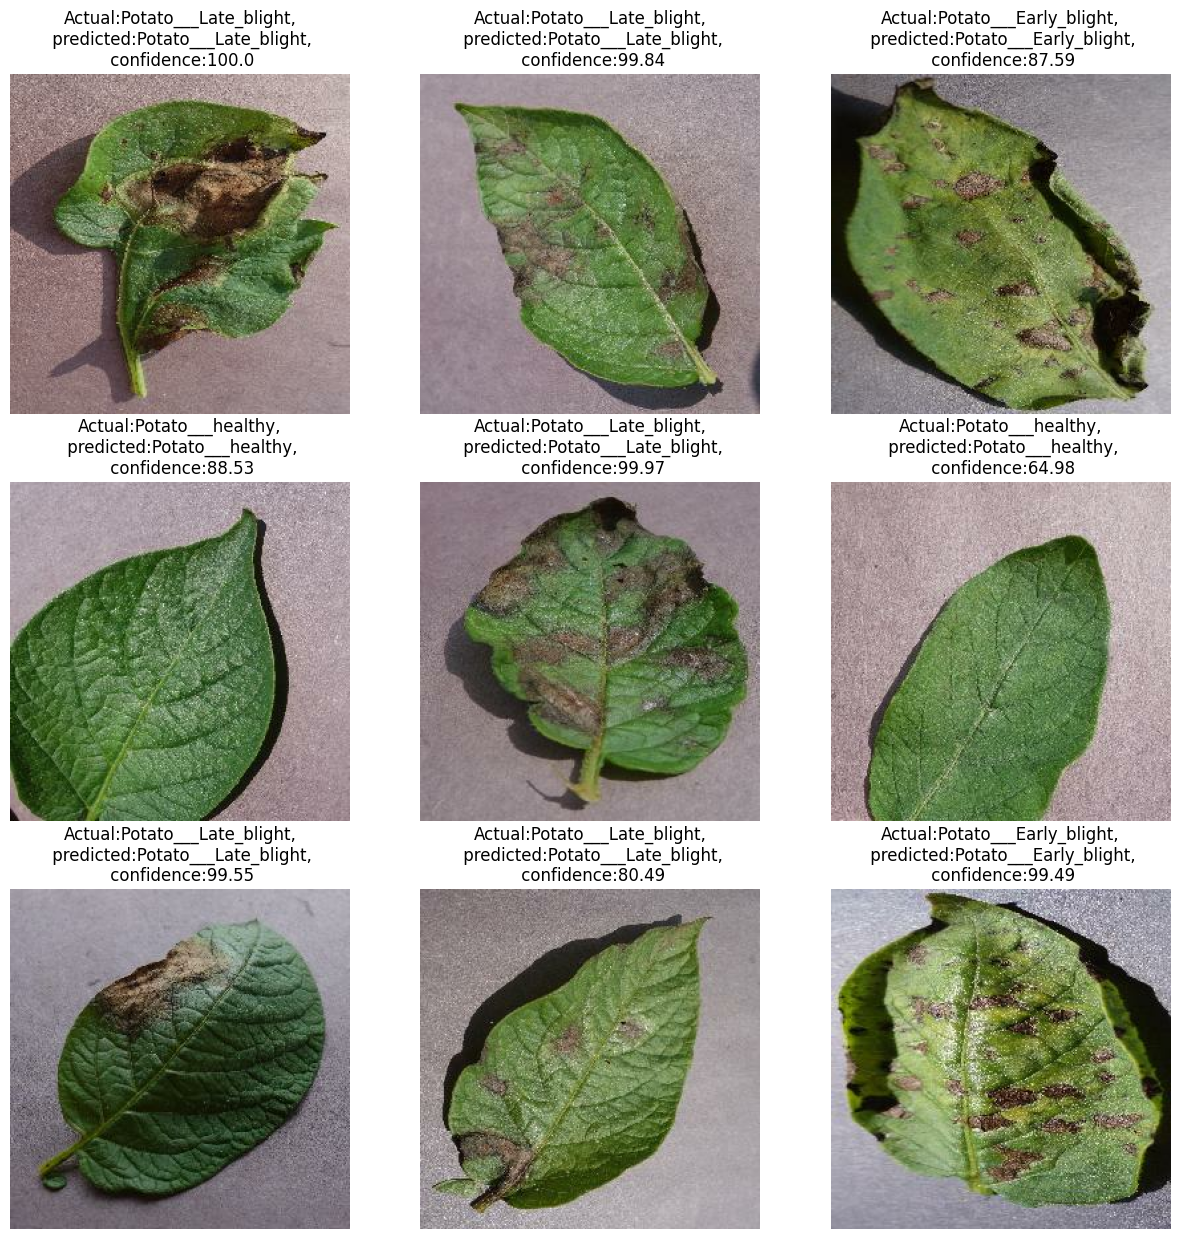

In [27]:
#Plot a grid of prediction with actual labels
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n predicted:{predicted_class},\n confidence:{confidence}")
        

In [28]:
#Saving the model
import os
model_version=len(os.listdir('../Models'))+1
model.save(f"../Models/{model_version}.keras")